In [1]:

import torch
import triton
import triton.language as tl
from copy import deepcopy
import os

/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


- 一共5个版本，v1v2v3性能较差，但是没有删，感觉更能体现实现一个kernel的过程和优化
- v4v5性能相当，建议使用v4进行跑benchmark

In [2]:

def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

def rotate_half_v2(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((x2, -x1), dim=-1)

def rotate_half_v3(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

# v1

In [6]:


@triton.jit
def _fused_apply_rope_fwd(X, X_R, X_EMBED, COS, SIN,
                        stride_xb, stride_xl, stride_xh, stride_xd,
                        stride_cb, stride_cl, stride_cd,
                        B, COS_B, L, H, D:tl.constexpr, BLOCK_H:  tl.constexpr,
                        ):
    pid = tl.program_id(0)
    off_l = pid % L
    x_offset = pid * stride_xl
    if B == COS_B:
        cos_offset = pid * stride_cl
    else:
        cos_offset = off_l * stride_cl
    # cos_offset = pid * stride_cl
    X += x_offset
    X_R += x_offset
    X_EMBED += x_offset
    COS += cos_offset
    SIN += cos_offset
    cols = tl.arange(0, D)
    cos_ptrs = COS + cols
    sin_ptrs = SIN + cols

    x_ptrs = tl.make_block_ptr(
        base=X,
        shape=(H, D),
        offsets=(0, 0),
        strides=(stride_xh, stride_xd),
        block_shape=(BLOCK_H, D),
        order=(1,0)
    )
    xr_ptrs = tl.make_block_ptr(
        base=X_R,
        shape=(H, D),
        offsets=(0, 0),
        strides=(stride_xh, stride_xd),
        block_shape=(BLOCK_H, D),
        order=(1,0)
    )
    xembed_ptrs = tl.make_block_ptr(
        base=X_EMBED,
        shape=(H, D),
        offsets=(0, 0),
        strides=(stride_xh, stride_xd),
        block_shape=(BLOCK_H, D),
        order=(1,0)
    )
    cos = tl.load(cos_ptrs)
    sin = tl.load(sin_ptrs)
    x = tl.load(x_ptrs, boundary_check=(0,), padding_option='zero')
    xr = tl.load(xr_ptrs, boundary_check=(0,), padding_option='zero')
    x_embed = x * cos[None, :] + xr * sin[None, :]
    tl.store(xembed_ptrs, x_embed, boundary_check=(0,))

@triton.jit
def _fused_apply_rope_bwd(DX_EMBED, DX_EMBED_R, DX, COS, SIN,
                        stride_xb, stride_xl, stride_xh, stride_xd,
                        stride_cb, stride_cl, stride_cd,
                        B, COS_B, L, H, D:tl.constexpr, BLOCK_H:  tl.constexpr,
                        ):
    pid = tl.program_id(0)
    off_l = pid % L
    x_offset = pid * stride_xl
    if B == COS_B:
        cos_offset = pid * stride_cl
    else:
        cos_offset = off_l * stride_cl
    # cos_offset = pid * stride_cl
    DX += x_offset
    DX_EMBED += x_offset
    DX_EMBED_R += x_offset
    COS += cos_offset
    SIN += cos_offset
    cols = tl.arange(0, D)
    cos_ptrs = COS + cols
    sin_ptrs = SIN + cols

    dx_ptrs = tl.make_block_ptr(
        base=DX,
        shape=(H, D),
        offsets=(0, 0),
        strides=(stride_xh, stride_xd),
        block_shape=(BLOCK_H, D),
        order=(1,0)
    )
    dx_embed_r_ptrs = tl.make_block_ptr(
        base=DX_EMBED_R,
        shape=(H, D),
        offsets=(0, 0),
        strides=(stride_xh, stride_xd),
        block_shape=(BLOCK_H, D),
        order=(1,0)
    )
    dx_embed_ptrs = tl.make_block_ptr(
        base=DX_EMBED,
        shape=(H, D),
        offsets=(0, 0),
        strides=(stride_xh, stride_xd),
        block_shape=(BLOCK_H, D),
        order=(1,0)
    )
    cos = tl.load(cos_ptrs)
    sin = tl.load(sin_ptrs)
    dx_embed_r = tl.load(dx_embed_r_ptrs, boundary_check=(0,), padding_option='zero')
    dx_embed = tl.load(dx_embed_ptrs, boundary_check=(0,), padding_option='zero')
    dx = dx_embed * cos[None, :] + dx_embed_r * sin[None, :]
    tl.store(dx_ptrs, dx, boundary_check=(0,))

class _FusedApplyRope(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, k, cos, sin):
        q = q.transpose(1,2)
        k = k.transpose(1,2)
        assert q.is_contiguous() and k.is_contiguous()
        qh = q.size(2)
        kh = k.size(2)
        x = torch.cat([q,k],axis=2)
        x_rotate_half = rotate_half(x)
        B, L, H, D = x.shape
        assert (D % 32 == 0) or (D % 64 == 0) or (D % 128 == 0)
        BLOCK_H = triton.next_power_of_2(H)
        x_embed = torch.empty_like(x)
        num_warps=4
        num_stages=4
        M = B*L
        COS_B = cos.shape[0]
        _fused_apply_rope_fwd[(M,)](x, x_rotate_half, x_embed, cos, sin,
                        *x.stride(),
                        *cos.stride(),
                        B, COS_B, L, H,D, BLOCK_H,
                        num_warps=num_warps, num_stages=num_stages

        )
        q_embed, k_embed = x_embed.split([qh, kh], dim=2)
        q_embed = q_embed.contiguous().transpose(1,2)
        k_embed = k_embed.contiguous().transpose(1,2)

        ctx.save_for_backward(cos, sin)
        # ctx.infos = (B, H, L, D, BLOCK_H, M, COS_B, qh, kh)
        # ctx.num_warps = num_warps
        # ctx.num_stages = num_stages
        return q_embed, k_embed
    
    @staticmethod
    def backward(ctx, dq_embed, dk_embed):
        # dq_embed = dq_embed.transpose(1,2)
        # dk_embed = dk_embed.transpose(1,2)
        
        # B, H, L, D, BLOCK_H, M, COS_B, qh, kh = ctx.infos

        # cos,sin = ctx.saved_tensors
        # sin = rotate_half_v2(sin)
        # dx_embed = torch.cat([dq_embed, dk_embed], axis=-2)
        # dx_embed_r = rotate_half_v3(dx_embed)
        # dx = torch.empty_like(dx_embed)
        
        # _fused_apply_rope_bwd[(M,)](dx_embed, dx_embed_r, dx, cos, sin,
        #                 *dx_embed.stride(),
        #                 *cos.stride(),
        #                 B, COS_B, L, H,D, BLOCK_H,
        #                 num_warps=ctx.num_warps, num_stages=ctx.num_stages

        # )
        # dq, dk = dx.split([qh, kh], dim=2)
        # dq = dq.transpose(1,2).contiguous()
        # dk = dk.transpose(1,2).contiguous()


        cos,sin = ctx.saved_tensors
        cos = cos.unsqueeze(1)
        sin = sin.unsqueeze(1)
        dq = dq_embed * cos + rotate_half_v2(sin) * rotate_half_v3(dq_embed)
        dk = dk_embed * cos + rotate_half_v2(sin) * rotate_half_v3(dk_embed)
        return dq, dk, None, None


fused_apply_rope = _FusedApplyRope.apply



# v2

In [7]:

def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

def rotate_half_v2(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((x2, -x1), dim=-1)

def rotate_half_v3(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

@triton.jit
def _fused_apply_rope_fwd(Q, K, QR, KR, COS, SIN,
                          Q_EMBED, K_EMBED,
                          stride_qb, stride_qh, stride_ql, stride_qd,
                          stride_qrb, stride_qrh, stride_qrl, stride_qrd,
                          stride_cb, stride_cl, stride_cd,
                          B, COS_B, L, QH, KH, D:tl.constexpr
                          ):
    pid = tl.program_id(0)
    off_b = pid // L
    off_l = pid % L
    q_offset = pid * stride_ql
    qr_offset = off_b * stride_qrb + off_l * stride_qrl
    factor = QH // KH
    k_offset = pid * stride_ql // factor
    kr_offset = off_b * stride_qrb // factor + off_l * stride_qrl
    if B == COS_B:
        cos_offset = pid * stride_cl
    else:
        cos_offset = off_l * stride_cl
    # cos_offset = pid * stride_cl
    Q += q_offset
    QR += qr_offset
    Q_EMBED += q_offset
    K += k_offset
    KR += kr_offset
    K_EMBED += k_offset
    COS += cos_offset
    SIN += cos_offset

    cols = tl.arange(0, D)
    q_ptrs = Q + cols
    qr_ptrs = QR + cols
    qembed_ptrs = Q_EMBED + cols
    k_ptrs = K + cols
    kr_ptrs = KR + cols
    kembed_ptrs = K_EMBED + cols
    cos_ptrs = COS + cols
    sin_ptrs = SIN + cols

    cos = tl.load(cos_ptrs)
    sin = tl.load(sin_ptrs)

    for idx in tl.range(0, QH):
        offset = D*idx
        offset_r = idx * stride_qrh
        q = tl.load(q_ptrs + offset)
        qr = tl.load(qr_ptrs + offset_r)
        q_embed = q * cos + qr * sin
        tl.store(qembed_ptrs + offset, q_embed)
        if idx % factor == 0:
            k = tl.load(k_ptrs + offset//factor)
            kr = tl.load(kr_ptrs + offset_r//factor)
            k_embed = k * cos + kr * sin
            tl.store(kembed_ptrs + offset//factor, k_embed)

    # for idx in tl.range(0, KH):
    #     offset = D*idx
    #     offset_r = idx * stride_qrh
    #     k = tl.load(k_ptrs + offset)
    #     kr = tl.load(kr_ptrs + offset_r)
    #     k_embed = k * cos + kr * sin
    #     tl.store(kembed_ptrs + offset, k_embed)

@triton.jit
def _fused_apply_rope_bwd(DQ_EMBED, DK_EMBED, DQ_EMBED_R, DK_EMBED_R, COS, SIN,
                          DQ, DK, 
                        stride_qb, stride_qh, stride_ql, stride_qd,
                        stride_kb, stride_kh, stride_kl, stride_kd,
                        stride_cb, stride_cl, stride_cd,
                        B, COS_B, L, QH, KH, D: tl.constexpr,
                        ):
    pid = tl.program_id(0)
    off_b = pid // L
    off_l = pid % L
    factor = QH // KH
    dq_offset = off_b * stride_qb + stride_ql * off_l
    dk_offset = off_b * stride_kb  + stride_kl * off_l
    if B == COS_B:
        cos_offset = pid * stride_cl
    else:
        cos_offset = off_l * stride_cl
    # cos_offset = pid * stride_cl
    DQ += dq_offset
    DQ_EMBED += dq_offset
    DQ_EMBED_R += dq_offset
    DK += dk_offset
    DK_EMBED += dk_offset
    DK_EMBED_R += dk_offset
    COS += cos_offset
    SIN += cos_offset

    cols = tl.arange(0, D)
    dq_ptrs = DQ + cols
    dq_embed_ptrs = DQ_EMBED + cols
    dq_embed_r_ptrs = DQ_EMBED_R + cols
    dk_ptrs = DK + cols
    dk_embed_ptrs = DK_EMBED + cols
    dk_embed_r_ptrs = DK_EMBED_R + cols
    cos_ptrs = COS + cols
    sin_ptrs = SIN + cols

    cos = tl.load(cos_ptrs)
    sin = tl.load(sin_ptrs)

    for idx in tl.range(0, QH):
        offset = stride_qh * idx
        dq_embed = tl.load(dq_embed_ptrs + offset)
        dq_embed_r = tl.load(dq_embed_r_ptrs + offset)
        dq = dq_embed * cos + dq_embed_r * sin
        tl.store(dq_ptrs + offset, dq)
        if idx % factor == 0:
            offset = idx * stride_kh // factor
            dk_embed = tl.load(dk_embed_ptrs + offset)
            dk_embed_r = tl.load(dk_embed_r_ptrs + offset)
            dk = dk_embed * cos + dk_embed_r * sin
            tl.store(dk_ptrs + offset, dk)

    # for idx in tl.range(0, KH):
    #     offset = idx * stride_kh
    #     dk_embed = tl.load(dk_embed_ptrs + offset)
    #     dk_embed_r = tl.load(dk_embed_r_ptrs + offset)
    #     dk = dk_embed * cos + dk_embed_r * sin
    #     tl.store(dk_ptrs + offset, dk)

class _FusedApplyRope(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, k, cos, sin):
        assert q.transpose(1,2).is_contiguous()
        # print(q.stride(), k.stride())
        B, QH, L, D = q.shape
        KH = k.size(1)
        assert (D % 32 == 0) or (D % 64 == 0) or (D % 128 == 0)
        num_stages=4
        num_warps=1

        qr = rotate_half(q)
        kr = rotate_half(k)
        # print(qr.stride())
        q_embed = torch.empty(B, L, QH, D, device=q.device, dtype=k.dtype)
        k_embed = torch.empty(B, L, KH, D, device=q.device, dtype=k.dtype)
        M = B*L
        COS_B = cos.shape[0]
        _fused_apply_rope_fwd[(M,)](q,k,qr,kr,cos, sin,
                                    q_embed, k_embed,
                                    *q.stride(),
                                    *qr.stride(),
                                    *cos.stride(),
                                    B, COS_B, L, QH, KH, D,
                                    num_warps=num_warps, num_stages=num_stages

        )

        ctx.save_for_backward(cos, sin)
        ctx.infos = (B, QH, KH, L, D, M, COS_B)
        ctx.num_warps = num_warps
        ctx.num_stages = num_stages
        return q_embed.transpose(1,2), k_embed.transpose(1,2)

    @staticmethod
    def backward(ctx, dq_embed, dk_embed):
        # print(dq_embed.shape, dq_embed.stride())
        B, QH, KH, L, D, M, COS_B = ctx.infos
        cos,sin = ctx.saved_tensors
        dq = torch.empty_like(dq_embed)
        dk = torch.empty_like(dk_embed)
        dq_embed_r = rotate_half_v3(dq_embed)
        dk_embed_r = rotate_half_v3(dk_embed)
        sin = rotate_half_v2(sin)
        _fused_apply_rope_bwd[(M,)](dq_embed, dk_embed, dq_embed_r, dk_embed_r, cos, sin,
                                    dq, dk,
                                    *dq.stride(),
                                    *dk.stride(),
                                    *cos.stride(),
                                    B, COS_B, L, QH, KH, D,
                                    num_warps=ctx.num_warps, num_stages=ctx.num_stages
                                    )
        print(dq.stride(), dq_embed.stride(), dq_embed_r.stride())
        print(dk.stride(), dk_embed.stride(), dk_embed_r.stride())
        return dq, dk, None, None


fused_apply_rope = _FusedApplyRope.apply



# v3

In [9]:
@triton.jit
def _fused_apply_rope_fwd(Q, K, QR, KR, COS, SIN,
                          Q_EMBED, K_EMBED,
                          stride_qb, stride_qh, stride_ql, stride_qd,
                          stride_qrb, stride_qrh, stride_qrl, stride_qrd,
                          stride_cb, stride_cl, stride_cd,
                          B, COS_B, L, QH, KH, D:tl.constexpr,BLOCK_QH:tl.constexpr, BLOCK_KH:tl.constexpr,
                          ):
    pid = tl.program_id(0)
    off_b = pid // L
    off_l = pid % L
    q_offset = pid * stride_ql
    qr_offset = off_b * stride_qrb + off_l * stride_qrl
    factor = QH // KH
    k_offset = pid * stride_ql // factor
    kr_offset = off_b * stride_qrb // factor + off_l * stride_qrl
    if B == COS_B:
        cos_offset = pid * stride_cl
    else:
        cos_offset = off_l * stride_cl
    # cos_offset = pid * stride_cl
    Q += q_offset
    QR += qr_offset
    Q_EMBED += q_offset
    K += k_offset
    KR += kr_offset
    K_EMBED += k_offset
    COS += cos_offset
    SIN += cos_offset
    q_block_ptrs = tl.make_block_ptr(
        base=Q,
        shape=(QH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_QH, D),
        order=(1,0)
    )
    qr_block_ptrs = tl.make_block_ptr(
        base=QR,
        shape=(QH, D),
        strides=(stride_qrh, stride_qrd),
        offsets=(0,0),
        block_shape=(BLOCK_QH, D),
        order=(1,0)
    )
    qembed_block_ptrs = tl.make_block_ptr(
        base=Q_EMBED,
        shape=(QH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_QH, D),
        order=(1,0)
    )
    k_block_ptrs = tl.make_block_ptr(
        base=K,
        shape=(KH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_KH, D),
        order=(1,0)
    )
    kr_block_ptrs = tl.make_block_ptr(
        base=KR,
        shape=(KH, D),
        strides=(stride_qrh, stride_qrd),
        offsets=(0,0),
        block_shape=(BLOCK_KH, D),
        order=(1,0)
    )
    kembed_block_ptrs = tl.make_block_ptr(
        base=K_EMBED,
        shape=(KH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_KH, D),
        order=(1,0)
    )

    cols = tl.arange(0, D)
    cos_ptrs = COS + cols
    sin_ptrs = SIN + cols
    cos = tl.load(cos_ptrs)
    dtype = cos.dtype
    cos = cos.to(tl.float32)
    sin = tl.load(sin_ptrs).to(tl.float32)

    q = tl.load(q_block_ptrs, boundary_check=(0,)).to(tl.float32)
    qr = tl.load(qr_block_ptrs, boundary_check=(0,)).to(tl.float32)
    q_embed = q * cos + qr * sin
    tl.store(qembed_block_ptrs, q_embed.to(dtype), boundary_check=(0,))
    k = tl.load(k_block_ptrs, boundary_check=(0,)).to(tl.float32)
    kr = tl.load(kr_block_ptrs, boundary_check=(0,)).to(tl.float32)
    k_embed = k * cos + kr * sin
    tl.store(kembed_block_ptrs, k_embed.to(dtype), boundary_check=(0,))


@triton.jit
def _fused_apply_rope_bwd(DQ_EMBED, DK_EMBED, DQ_EMBED_R, DK_EMBED_R, COS, SIN,
                          DQ, DK, 
                        stride_qb, stride_qh, stride_ql, stride_qd,
                        stride_qrb, stride_qrh, stride_qrl, stride_qrd,
                        stride_kb, stride_kh, stride_kl, stride_kd,
                        stride_krb, stride_krh, stride_krl, stride_krd,
                        stride_cb, stride_cl, stride_cd,
                        B, COS_B, L, QH, KH, D: tl.constexpr, BLOCK_QH:tl.constexpr, BLOCK_KH:tl.constexpr,
                        ):
    pid = tl.program_id(0)
    off_b = pid // L
    off_l = pid % L
    dq_offset = off_b * stride_qb + stride_ql * off_l
    dqr_offset = off_b * stride_qrb + stride_qrl * off_l
    dk_offset = off_b * stride_kb  + stride_kl * off_l
    dkr_offset = off_b * stride_krb  + stride_krl * off_l
    if B == COS_B:
        cos_offset = pid * stride_cl
    else:
        cos_offset = off_l * stride_cl
    # cos_offset = pid * stride_cl
    DQ += dq_offset
    DQ_EMBED += dq_offset
    DQ_EMBED_R += dqr_offset
    DK += dk_offset
    DK_EMBED += dk_offset
    DK_EMBED_R += dkr_offset
    COS += cos_offset
    SIN += cos_offset

    dq_block_ptrs = tl.make_block_ptr(
        base=DQ,
        shape=(QH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_QH, D),
        order=(1,0)
    )
    dq_embed_block_ptrs = tl.make_block_ptr(
        base=DQ_EMBED,
        shape=(QH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_QH, D),
        order=(1,0)
    )
    dq_embed_r_block_ptrs = tl.make_block_ptr(
        base=DQ_EMBED_R,
        shape=(QH, D),
        strides=(stride_qrh, stride_qrd),
        offsets=(0,0),
        block_shape=(BLOCK_QH, D),
        order=(1,0)
    )
    dk_block_ptrs = tl.make_block_ptr(
        base=DK,
        shape=(KH, D),
        strides=(stride_kh, stride_kd),
        offsets=(0,0),
        block_shape=(BLOCK_KH, D),
        order=(1,0)
    )
    dk_embed_block_ptrs = tl.make_block_ptr(
        base=DK_EMBED,
        shape=(KH, D),
        strides=(stride_kh, stride_kd),
        offsets=(0,0),
        block_shape=(BLOCK_KH, D),
        order=(1,0)
    )
    dk_embed_r_block_ptrs = tl.make_block_ptr(
        base=DK_EMBED_R,
        shape=(KH, D),
        strides=(stride_krh, stride_krd),
        offsets=(0,0),
        block_shape=(BLOCK_KH, D),
        order=(1,0)
    )
    cols = tl.arange(0, D)
    cos_ptrs = COS + cols
    sin_ptrs = SIN + cols

    cos = tl.load(cos_ptrs)
    dtype = cos.dtype
    cos = cos.to(tl.float32)
    sin = tl.load(sin_ptrs).to(tl.float32)

    dq_embed = tl.load(dq_embed_block_ptrs, boundary_check=(0,)).to(tl.float32)
    dq_embed_r = tl.load(dq_embed_r_block_ptrs, boundary_check=(0,)).to(tl.float32)
    dq = dq_embed * cos + dq_embed_r * sin
    tl.store(dq_block_ptrs, dq.to(dtype), boundary_check=(0,))
    dk_embed = tl.load(dk_embed_block_ptrs, boundary_check=(0,)).to(tl.float32)
    dk_embed_r = tl.load(dk_embed_r_block_ptrs, boundary_check=(0,)).to(tl.float32)
    dk = dk_embed * cos + dk_embed_r * sin
    tl.store(dk_block_ptrs, dk.to(dtype), boundary_check=(0,))

class _FusedApplyRope(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, k, cos, sin):
        assert q.transpose(1,2).is_contiguous()
        # print(q.stride(), k.stride())
        B, QH, L, D = q.shape
        KH = k.size(1)
        assert (D % 32 == 0) or (D % 64 == 0) or (D % 128 == 0)
        num_stages=1
        num_warps=8

        qr = rotate_half(q)
        kr = rotate_half(k)
        # print(qr.stride())
        q_embed = torch.empty(B, L, QH, D, device=q.device, dtype=k.dtype)
        k_embed = torch.empty(B, L, KH, D, device=q.device, dtype=k.dtype)
        M = B*L
        COS_B = cos.shape[0]
        BLOCK_QH = triton.next_power_of_2(QH)
        BLOCK_KH = triton.next_power_of_2(KH)
        _fused_apply_rope_fwd[(M,)](q,k,qr,kr,cos, sin,
                                    q_embed, k_embed,
                                    *q.stride(),
                                    *qr.stride(),
                                    *cos.stride(),
                                    B, COS_B, L, QH, KH, D, BLOCK_QH, BLOCK_KH,
                                    num_warps=num_warps, num_stages=num_stages

        )

        ctx.save_for_backward(cos, sin)
        ctx.infos = (B, QH, KH, L, D, M, COS_B, BLOCK_QH, BLOCK_KH)
        ctx.num_warps = num_warps
        ctx.num_stages = num_stages
        return q_embed.transpose(1,2), k_embed.transpose(1,2)

    @staticmethod
    def backward(ctx, dq_embed, dk_embed):
        B, QH, KH, L, D, M, COS_B ,BLOCK_QH, BLOCK_KH= ctx.infos
        cos,sin = ctx.saved_tensors
        dq = torch.empty_like(dq_embed)
        dk = torch.empty_like(dk_embed)
        dq_embed_r = rotate_half_v3(dq_embed)
        dk_embed_r = rotate_half_v3(dk_embed)
        sin = rotate_half_v2(sin)
        _fused_apply_rope_bwd[(M,)](dq_embed, dk_embed, dq_embed_r, dk_embed_r, cos, sin,
                                    dq, dk,
                                    *dq.stride(),
                                    *dq_embed_r.stride(),
                                    *dk.stride(),
                                    *dk_embed_r.stride(),
                                    *cos.stride(),
                                    B, COS_B, L, QH, KH, D, BLOCK_QH, BLOCK_KH,
                                    num_warps=ctx.num_warps, num_stages=ctx.num_stages
                                    )
        # 不同模型传回来的stride都不一样，有的dk_embed是连续的，有的不连续
        # 因此跟forward不太一样，需要把所有stride都传进去
        return dq, dk, None, None

fused_apply_rope = _FusedApplyRope.apply

# unsloth

In [21]:
ROPE_GROUP_SIZE = 4
@triton.heuristics({"BACKWARD_PASS": lambda args: bool(args["BACKWARD_PASS"]),})
@triton.jit
def _rope_embedding(
    Q,     Q_row_stride,
    cos, cos_row_stride,
    sin, sin_row_stride,
    seqlen,
    head_dim      : tl.constexpr,
    n_heads       : tl.constexpr,
    BACKWARD_PASS : tl.constexpr,
    BLOCK_SIZE    : tl.constexpr,
):
    """
        Calculates the RoPE Embedding quickly
        RoPE is Q * cos + rotate_half(Q) * sin
        See our blog post for more info
    """
    ROPE_GROUP_SIZE = 4
    row_position  = tl.program_id(0)
    group_head_position = tl.program_id(1)
    col_offsets  = tl.arange(0, BLOCK_SIZE)
    half_head_dim = head_dim // 2
    mask = col_offsets < half_head_dim

    sin1 = tl.load(sin + (row_position % seqlen)*sin_row_stride + \
                   half_head_dim*0 + col_offsets, mask = mask, other = 0)
    cos1 = tl.load(cos + (row_position % seqlen)*cos_row_stride + \
                   half_head_dim*0 + col_offsets, mask = mask, other = 0)

    if BACKWARD_PASS:
        # See our blog post for more info.
        sin1 = -sin1
    pass

    # [TODO] Autotune ROPE_GROUP_SIZE to be 1, 2, 4, 8
    head_start = group_head_position * ROPE_GROUP_SIZE
    head_end = min((head_start + ROPE_GROUP_SIZE), n_heads)

    # 10% Faster kernel from [HuyNguyen-hust](https://github.com/unslothai/unsloth/pull/238)
    for k in range(head_start, head_end):
        offs_q1 = row_position * Q_row_stride + k * head_dim + col_offsets
        offs_q2 = row_position * Q_row_stride + k * head_dim + col_offsets + half_head_dim

        # For Gemma - sometimes RoPE must be done in float32 and not bfloat16
        Q1 = tl.load(Q + offs_q1, mask = mask, other = 0).to(sin1.dtype)
        Q2 = tl.load(Q + offs_q2, mask = mask, other = 0).to(sin1.dtype)

        tl.store(Q + offs_q1, Q1*cos1 - Q2*sin1, mask = mask)
        tl.store(Q + offs_q2, Q2*cos1 + Q1*sin1, mask = mask)
    pass
pass


class Fast_RoPE_Embedding(torch.autograd.Function):
    @staticmethod
    def forward(ctx, Q, cos, sin):
        cos, sin = cos.squeeze(), sin.squeeze()
        batch    : int
        seq_len  : int
        n_heads  : int
        head_dim : int
        batch, seq_len, n_heads, head_dim = Q.shape
        Q = Q.view(batch*seq_len, n_heads*head_dim)
        n_rows : int
        n_cols : int
        n_rows, n_cols = Q.shape
        assert(seq_len <= cos.shape[0])

        # [TODO] Changing blocksize to head_dim//2 seems to have
        # some concurrency / un-deterministic issues.
        BLOCK_SIZE, num_warps = head_dim//2, 8 # (head_dim//2)
        
        # group_size = 4 # 4 or 8, too large group_size can hurt performance.
        div : int
        mod : int
        div, mod = divmod(n_heads, ROPE_GROUP_SIZE)
        n_groups : int = div + (mod != 0)

        _rope_embedding[(n_rows, n_groups, )](
              Q,   Q.stride(0),
            cos, cos.stride(0),
            sin, sin.stride(0),
            seq_len,
            head_dim, n_heads,
            BACKWARD_PASS = False,
            BLOCK_SIZE = BLOCK_SIZE,
            num_warps  = num_warps,
        )
        ctx.BLOCK_SIZE = BLOCK_SIZE
        ctx.num_warps  = num_warps
        ctx.n_groups = n_groups
        ctx.cos = cos
        ctx.sin = sin
        return Q.view(batch, seq_len, n_heads, head_dim)
    pass

    @staticmethod
    def backward(ctx, dY):
        batch    : int
        seq_len  : int
        n_heads  : int
        head_dim : int
        batch, seq_len, n_heads, head_dim = dY.shape
        dY = dY.reshape(batch*seq_len, n_heads*head_dim)
        # Must be reshape not view
        n_rows : int
        n_cols : int
        n_rows, n_cols = dY.shape

        cos = ctx.cos
        sin = ctx.sin

        _rope_embedding[(n_rows, ctx.n_groups, )](
            dY,  dY .stride(0),
            cos, cos.stride(0),
            sin, sin.stride(0),
            seq_len, head_dim, n_heads,
            BACKWARD_PASS = True,
            BLOCK_SIZE = ctx.BLOCK_SIZE,
            num_warps  = ctx.num_warps,
        )
        dY = dY.view(batch, seq_len, n_heads, head_dim)
        return dY, None, None,
    pass
pass

# [TODO] Unsure why RoPE Embedding is not torch.compiling properly
@torch.compiler.disable
def fast_rope_embedding(Q, K, cos, sin):
    Q = Fast_RoPE_Embedding.apply(Q.transpose(1, 2), cos, sin).transpose(1, 2)
    K = Fast_RoPE_Embedding.apply(K.transpose(1, 2), cos, sin).transpose(1, 2)
    return Q, K
pass

# v4

- unsloth的没跑起来，貌似传参和HF中的不太一样，不过我借鉴了它实现翻转的方式，v4是在v3上进行升级，去掉外部的翻转

In [ ]:
@triton.jit
def _fused_apply_rope_fwd(Q, K, COS, SIN,
                          Q_EMBED, K_EMBED,
                          stride_qb, stride_qh, stride_ql, stride_qd,
                          stride_cb, stride_cl, stride_cd,
                          B, COS_B, L, QH, KH, D:tl.constexpr, HALF_D:tl.constexpr,
                          BLOCK_QH:tl.constexpr, BLOCK_KH:tl.constexpr,
                          ):
    pid = tl.program_id(0)
    off_b = pid // L
    off_l = pid % L
    q_offset = pid * stride_ql
    factor = QH // KH
    k_offset = pid * stride_ql // factor
    if B == COS_B:
        cos_offset = pid * stride_cl
    else:
        cos_offset = off_l * stride_cl
    # cos_offset = pid * stride_cl
    Q += q_offset
    Q_EMBED += q_offset
    K += k_offset
    K_EMBED += k_offset
    COS += cos_offset
    SIN += cos_offset
    q_block_ptrs = tl.make_block_ptr(
        base=Q,
        shape=(QH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_QH, HALF_D),
        order=(1,0)
    )
    qembed_block_ptrs = tl.make_block_ptr(
        base=Q_EMBED,
        shape=(QH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_QH, HALF_D),
        order=(1,0)
    )
    k_block_ptrs = tl.make_block_ptr(
        base=K,
        shape=(KH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_KH, HALF_D),
        order=(1,0)
    )
    kembed_block_ptrs = tl.make_block_ptr(
        base=K_EMBED,
        shape=(KH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_KH, HALF_D),
        order=(1,0)
    )

    cols1 = tl.arange(0, HALF_D)
    cols2 = tl.arange(HALF_D, D)
    cos1 = tl.load(COS + cols1)
    dtype = cos1.dtype
    cos1 = cos1.to(tl.float32)
    cos2 = tl.load(COS + cols2)
    sin1 = tl.load(SIN + cols1)
    sin2 = tl.load(SIN + cols2)

    k1 = tl.load(k_block_ptrs, boundary_check=(0,)).to(tl.float32)
    k_block_ptrs = tl.advance(k_block_ptrs, offsets=(0, HALF_D))
    k2 = tl.load(k_block_ptrs, boundary_check=(0,)).to(tl.float32)
    k_embed1 = k1 * cos1 - k2 * sin1
    k_embed2 = k2 * cos2 + k1 * sin2
    tl.store(kembed_block_ptrs, k_embed1.to(dtype), boundary_check=(0,))
    kembed_block_ptrs = tl.advance(kembed_block_ptrs, offsets=(0, HALF_D))
    tl.store(kembed_block_ptrs, k_embed2.to(dtype), boundary_check=(0,))
    
    q1 = tl.load(q_block_ptrs, boundary_check=(0,)).to(tl.float32)
    q_block_ptrs = tl.advance(q_block_ptrs, offsets=(0, HALF_D))
    q2 = tl.load(q_block_ptrs, boundary_check=(0,)).to(tl.float32)
    q_embed1 = q1 * cos1 - q2 * sin1
    q_embed2 = q2 * cos2 + q1 * sin2
    tl.store(qembed_block_ptrs, q_embed1.to(dtype), boundary_check=(0,))
    qembed_block_ptrs = tl.advance(qembed_block_ptrs, offsets=(0, HALF_D))
    tl.store(qembed_block_ptrs, q_embed2.to(dtype), boundary_check=(0,))
    





@triton.jit
def _fused_apply_rope_bwd(DQ_EMBED, DK_EMBED, COS, SIN,
                          DQ, DK, 
                        stride_qb, stride_qh, stride_ql, stride_qd,
                        stride_kb, stride_kh, stride_kl, stride_kd,
                        stride_cb, stride_cl, stride_cd,
                        B, COS_B, L, QH, KH, D: tl.constexpr, HALF_D: tl.constexpr,
                        BLOCK_QH:tl.constexpr, BLOCK_KH:tl.constexpr,
                        ):
    pid = tl.program_id(0)
    off_b = pid // L
    off_l = pid % L
    dq_offset = off_b * stride_qb + stride_ql * off_l
    dk_offset = off_b * stride_kb  + stride_kl * off_l
    if B == COS_B:
        cos_offset = pid * stride_cl
    else:
        cos_offset = off_l * stride_cl
    # cos_offset = pid * stride_cl
    DQ += dq_offset
    DQ_EMBED += dq_offset
    DK += dk_offset
    DK_EMBED += dk_offset
    COS += cos_offset
    SIN += cos_offset

    dq_block_ptrs = tl.make_block_ptr(
        base=DQ,
        shape=(QH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_QH, HALF_D),
        order=(1,0)
    )
    dq_embed_block_ptrs = tl.make_block_ptr(
        base=DQ_EMBED,
        shape=(QH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_QH, HALF_D),
        order=(1,0)
    )
    dk_block_ptrs = tl.make_block_ptr(
        base=DK,
        shape=(KH, D),
        strides=(stride_kh, stride_kd),
        offsets=(0,0),
        block_shape=(BLOCK_KH, HALF_D),
        order=(1,0)
    )
    dk_embed_block_ptrs = tl.make_block_ptr(
        base=DK_EMBED,
        shape=(KH, D),
        strides=(stride_kh, stride_kd),
        offsets=(0,0),
        block_shape=(BLOCK_KH, HALF_D),
        order=(1,0)
    )
    cols1 = tl.arange(0, HALF_D)
    cols2 = tl.arange(HALF_D, D)
    cos1 = tl.load(COS + cols1)
    dtype = cos1.dtype
    cos1 = cos1.to(tl.float32)
    cos2 = tl.load(COS + cols2)
    sin1 = tl.load(SIN + cols1)
    sin2 = tl.load(SIN + cols2)

    dk_embed1 = tl.load(dk_embed_block_ptrs, boundary_check=(0,)).to(tl.float32)
    dk_embed_block_ptrs = tl.advance(dk_embed_block_ptrs, offsets=(0, HALF_D))
    dk_embed2 = tl.load(dk_embed_block_ptrs, boundary_check=(0,)).to(tl.float32)
    dk1 = dk_embed1 * cos1 + sin2 * dk_embed2
    dk2 = dk_embed2 * cos2 - sin1 * dk_embed1
    tl.store(dk_block_ptrs, dk1.to(dtype), boundary_check=(0,))
    dk_block_ptrs = tl.advance(dk_block_ptrs, offsets=(0, HALF_D))
    tl.store(dk_block_ptrs, dk2.to(dtype), boundary_check=(0,))

    dq_embed1 = tl.load(dq_embed_block_ptrs, boundary_check=(0,)).to(tl.float32)
    dq_embed_block_ptrs = tl.advance(dq_embed_block_ptrs, offsets=(0, HALF_D))
    dq_embed2 = tl.load(dq_embed_block_ptrs, boundary_check=(0,)).to(tl.float32)
    dq1 = dq_embed1 * cos1 + sin2 * dq_embed2
    dq2 = dq_embed2 * cos2 - sin1 * dq_embed1
    tl.store(dq_block_ptrs, dq1.to(dtype), boundary_check=(0,))
    dq_block_ptrs = tl.advance(dq_block_ptrs, offsets=(0, HALF_D))
    tl.store(dq_block_ptrs, dq2.to(dtype), boundary_check=(0,))

class _FusedApplyRope(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, k, cos, sin):
        assert q.transpose(1,2).is_contiguous()
        # print(q.stride(), k.stride())
        B, QH, L, D = q.shape
        HALF_D = D // 2
        KH = k.size(1)
        assert (D % 32 == 0) or (D % 64 == 0) or (D % 128 == 0)
        num_stages=4
        num_warps=8

        # print(qr.stride())
        q_embed = torch.empty(B, L, QH, D, device=q.device, dtype=k.dtype)
        k_embed = torch.empty(B, L, KH, D, device=q.device, dtype=k.dtype)
        M = B*L
        COS_B = cos.shape[0]
        BLOCK_QH = triton.next_power_of_2(QH)
        BLOCK_KH = triton.next_power_of_2(KH)
        _fused_apply_rope_fwd[(M,)](q,k,cos, sin,
                                    q_embed, k_embed,
                                    *q.stride(),
                                    *cos.stride(),
                                    B, COS_B, L, QH, KH, D, HALF_D,
                                    BLOCK_QH, BLOCK_KH,
                                    num_warps=num_warps, num_stages=num_stages

        )

        ctx.save_for_backward(cos, sin)
        ctx.infos = (B, QH, KH, L, D, HALF_D, M, COS_B, BLOCK_QH, BLOCK_KH)
        ctx.num_warps = num_warps
        ctx.num_stages = num_stages
        return q_embed.transpose(1,2), k_embed.transpose(1,2)

    @staticmethod
    def backward(ctx, dq_embed, dk_embed):
        # print(dq_embed.stride(), dk_embed.stride())
        B, QH, KH, L, D, HALF_D, M, COS_B, BLOCK_QH, BLOCK_KH = ctx.infos
        cos,sin = ctx.saved_tensors
        dq = torch.empty_like(dq_embed)
        dk = torch.empty_like(dk_embed)
        _fused_apply_rope_bwd[(M,)](dq_embed, dk_embed, cos, sin,
                                    dq, dk,
                                    *dq.stride(),
                                    *dk.stride(),
                                    *cos.stride(),
                                    B, COS_B, L, QH, KH, D, HALF_D, BLOCK_QH, BLOCK_KH,
                                    num_warps=ctx.num_warps, num_stages=ctx.num_stages
                                    )
        return dq, dk, None, None

fused_apply_rope = _FusedApplyRope.apply

# v5

- q,k计算分离, v5比v4 forward慢一些，backward测试有问题，估计是loss的计算方式问题

In [74]:
@triton.jit
def _fused_apply_rope_fwd(Q, COS, SIN,
                          Q_EMBED,
                          stride_qb, stride_qh, stride_ql, stride_qd,
                          stride_cb, stride_cl, stride_cd,
                          B, COS_B, L, H, D:tl.constexpr, HALF_D:tl.constexpr,
                          BLOCK_H:tl.constexpr
                          ):
    pid = tl.program_id(0)
    off_b = pid // L
    off_l = pid % L
    q_offset = pid * stride_ql
    if B == COS_B:
        cos_offset = pid * stride_cl
    else:
        cos_offset = off_l * stride_cl
    # cos_offset = pid * stride_cl
    Q += q_offset
    Q_EMBED += q_offset
    COS += cos_offset
    SIN += cos_offset
    q_block_ptrs = tl.make_block_ptr(
        base=Q,
        shape=(H, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_H, HALF_D),
        order=(1,0)
    )
    qembed_block_ptrs = tl.make_block_ptr(
        base=Q_EMBED,
        shape=(H, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_H, HALF_D),
        order=(1,0)
    )

    cols1 = tl.arange(0, HALF_D)
    cols2 = tl.arange(HALF_D, D)
    cos1 = tl.load(COS + cols1)
    dtype = cos1.dtype
    cos1 = cos1.to(tl.float32)
    cos2 = tl.load(COS + cols2)
    sin1 = tl.load(SIN + cols1)
    sin2 = tl.load(SIN + cols2)

    q1 = tl.load(q_block_ptrs, boundary_check=(0,)).to(tl.float32)
    q_block_ptrs = tl.advance(q_block_ptrs, offsets=(0, HALF_D))
    q2 = tl.load(q_block_ptrs, boundary_check=(0,)).to(tl.float32)
    q_embed1 = q1 * cos1 - q2 * sin1
    q_embed2 = q2 * cos2 + q1 * sin2
    tl.store(qembed_block_ptrs, q_embed1.to(dtype), boundary_check=(0,))
    qembed_block_ptrs = tl.advance(qembed_block_ptrs, offsets=(0, HALF_D))
    tl.store(qembed_block_ptrs, q_embed2.to(dtype), boundary_check=(0,))
    
@triton.jit
def _fused_apply_rope_bwd(DQ_EMBED, COS, SIN,
                          DQ,
                        stride_qb, stride_qh, stride_ql, stride_qd,
                        stride_cb, stride_cl, stride_cd,
                        B, COS_B, L, H, D: tl.constexpr, HALF_D: tl.constexpr,
                        BLOCK_H:tl.constexpr
                        ):
    pid = tl.program_id(0)
    off_b = pid // L
    off_l = pid % L
    dq_offset = off_b * stride_qb + stride_ql * off_l
    if B == COS_B:
        cos_offset = pid * stride_cl
    else:
        cos_offset = off_l * stride_cl
    # cos_offset = pid * stride_cl
    DQ += dq_offset
    DQ_EMBED += dq_offset
    COS += cos_offset
    SIN += cos_offset

    dq_block_ptrs = tl.make_block_ptr(
        base=DQ,
        shape=(H, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_H, HALF_D),
        order=(1,0)
    )
    dq_embed_block_ptrs = tl.make_block_ptr(
        base=DQ_EMBED,
        shape=(H, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_H, HALF_D),
        order=(1,0)
    )

    cols1 = tl.arange(0, HALF_D)
    cols2 = tl.arange(HALF_D, D)
    cos1 = tl.load(COS + cols1)
    dtype = cos1.dtype
    cos1 = cos1.to(tl.float32)
    cos2 = tl.load(COS + cols2)
    sin1 = tl.load(SIN + cols1)
    sin2 = tl.load(SIN + cols2)

    dq_embed1 = tl.load(dq_embed_block_ptrs, boundary_check=(0,)).to(tl.float32)
    dq_embed_block_ptrs = tl.advance(dq_embed_block_ptrs, offsets=(0, HALF_D))
    dq_embed2 = tl.load(dq_embed_block_ptrs, boundary_check=(0,)).to(tl.float32)
    dq1 = dq_embed1 * cos1 + sin2 * dq_embed2
    dq2 = dq_embed2 * cos2 - sin1 * dq_embed1
    tl.store(dq_block_ptrs, dq1.to(dtype), boundary_check=(0,))
    dq_block_ptrs = tl.advance(dq_block_ptrs, offsets=(0, HALF_D))
    tl.store(dq_block_ptrs, dq2.to(dtype), boundary_check=(0,))

class _FusedApplyRope(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, cos, sin):
        assert q.transpose(1,2).is_contiguous()
        # print(q.stride(), k.stride())
        B, H, L, D = q.shape
        HALF_D = D // 2
        assert (D % 32 == 0) or (D % 64 == 0) or (D % 128 == 0)
        num_stages=4
        num_warps=8

        # print(qr.stride())
        q_embed = torch.empty(B, L, H, D, device=q.device, dtype=q.dtype)
        M = B*L
        COS_B = cos.shape[0]
        BLOCK_H = triton.next_power_of_2(H)
        _fused_apply_rope_fwd[(M,)](q,cos, sin,
                                    q_embed,
                                    *q.stride(),
                                    *cos.stride(),
                                    B, COS_B, L, H, D, HALF_D,
                                    BLOCK_H,
                                    num_warps=num_warps, num_stages=num_stages

        )

        ctx.save_for_backward(cos, sin)
        ctx.infos = (B, L, H, D, HALF_D, M, COS_B, BLOCK_H)
        ctx.num_warps = num_warps
        ctx.num_stages = num_stages
        return q_embed.transpose(1,2)

    @staticmethod
    def backward(ctx, dq_embed):
        B, L, H, D, HALF_D, M, COS_B, BLOCK_H = ctx.infos
        cos,sin = ctx.saved_tensors
        dq = torch.empty_like(dq_embed)
        _fused_apply_rope_bwd[(M,)](dq_embed, cos, sin,
                                    dq,
                                    *dq.stride(),
                                    *cos.stride(),
                                    B, COS_B, L, H, D, HALF_D, BLOCK_H,
                                    num_warps=ctx.num_warps, num_stages=ctx.num_stages
                                    )
        return dq, None, None

_fused_apply_rope = _FusedApplyRope.apply
def fused_apply_rope(q, k, cos, sin):
    return _fused_apply_rope(q,cos,sin), _fused_apply_rope(k, cos, sin)

# 精度测试

In [10]:
device = 'cuda'
dtype = torch.float32
bs, seq_len, num_q_head, num_k_head, head_dim = 4, 128, 14, 14, 64
q1 = torch.randn(bs, seq_len, num_q_head, head_dim, device=device, dtype=dtype).transpose(1,2)
q1.requires_grad_(True)
k1  = torch.randn(bs, seq_len, num_k_head, head_dim,device=device, dtype=dtype).transpose(1,2)
k1.requires_grad_(True)
q2 = torch.randn(bs, seq_len, num_q_head, head_dim, device=device, dtype=dtype).transpose(1,2)
q2.data.copy_(q1.data)
q2.requires_grad_(True)
k2  = torch.randn(bs, seq_len, num_k_head, head_dim, device=device, dtype=dtype).transpose(1,2)
k2.data.copy_(k1.data)
k2.requires_grad_(True)
cos = torch.randn(bs, seq_len, head_dim, device=device, dtype=dtype)
sin = torch.randn_like(cos)


In [11]:
if k1.grad is not None:
    k1.grad.zero_()
    q1.grad.zero_()
q_embed1, k_embed1 = apply_rotary_pos_emb(q1, k1, cos, sin)
# print(q_embed1.stride())
loss = (q_embed1 * repeat_kv(k_embed1, num_q_head//num_k_head))
print(loss.stride())
loss.sum().backward()

if k2.grad is not None:
    k2.grad.zero_()
    q2.grad.zero_()
q_embed2, k_embed2 = fused_apply_rope(q2, k2, cos, sin)
# print(q_embed2.stride())
loss = (q_embed2 * repeat_kv(k_embed2, num_q_head//num_k_head))
print(loss.stride())
loss.sum().backward()

print(torch.allclose(q_embed1, q_embed2, atol=1e-3), torch.allclose(k_embed1, k_embed2, atol=1e-3))
print(torch.allclose(q1.grad, q2.grad, atol=1e-3), torch.allclose(k1.grad, k2.grad, atol=1e-3))

(114688, 64, 896, 1)
(114688, 64, 896, 1)
(114688, 64, 896, 1) (114688, 64, 896, 1)
True True
True True


In [51]:
k1.grad[0][0]

tensor([[ 0.9595,  0.1466, -0.1726,  ...,  3.6958,  2.6310, -0.1132],
        [-1.2281,  0.8592, -2.6498,  ...,  0.7269, -1.2840, -5.1542],
        [ 1.7180,  1.4977,  2.9248,  ..., -1.3487, -1.4520, -0.6237],
        ...,
        [-2.8200, -0.1515,  3.1593,  ...,  0.4065, -0.7745, -0.6251],
        [-0.7797, -2.9620, -0.2275,  ...,  2.6334, -1.8935, -0.8047],
        [-0.8035,  0.6453, -0.1204,  ..., -1.9242, -0.1069,  3.3431]],
       device='cuda:0')

In [52]:
k2.grad[0][0]

tensor([[ 0.9595,  0.1466, -0.1726,  ...,  3.6958,  2.6310, -0.1132],
        [-1.2281,  0.8592, -2.6498,  ...,  0.7269, -1.2840, -5.1542],
        [ 1.7180,  1.4977,  2.9248,  ..., -1.3487, -1.4520, -0.6237],
        ...,
        [-2.8200, -0.1515,  3.1593,  ...,  0.4065, -0.7745, -0.6251],
        [-0.7797, -2.9620, -0.2275,  ...,  2.6334, -1.8935, -0.8047],
        [-0.8035,  0.6453, -0.1204,  ..., -1.9242, -0.1069,  3.3431]],
       device='cuda:0')

In [23]:
k1.grad.stride() == k2.grad.stride()

True

In [24]:
q_embed1.stride() == q_embed2.stride()

True

# forward
- v4比v5稍微快些

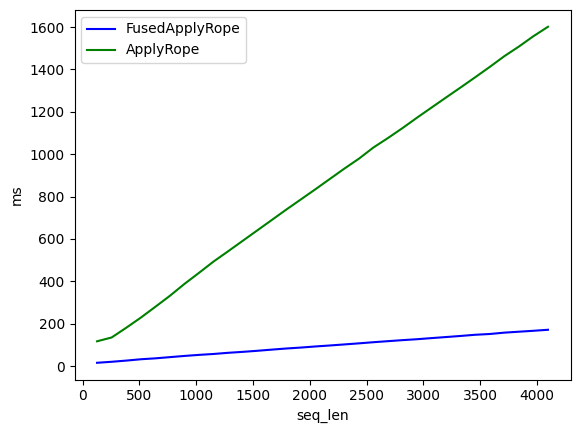

forward:
    seq_len  FusedApplyRope    ApplyRope
0     128.0       15.194470   116.685942
1     256.0       19.945122   134.578019
2     384.0       25.497630   180.259064
3     512.0       31.798527   227.970511
4     640.0       36.131088   279.104412
5     768.0       41.812088   330.967933
6     896.0       47.446355   387.060106
7    1024.0       52.479051   439.308196
8    1152.0       56.732580   492.661029
9    1280.0       62.243424   541.087389
10   1408.0       66.685379   590.263188
11   1536.0       71.708053   639.357746
12   1664.0       77.235274   688.603580
13   1792.0       82.525663   737.886369
14   1920.0       86.971827   785.797238
15   2048.0       92.192434   833.740175
16   2176.0       96.828409   882.724464
17   2304.0      101.820946   931.663871
18   2432.0      106.902197   978.465497
19   2560.0      112.300798  1031.420469
20   2688.0      117.228530  1076.128721
21   2816.0      122.041196  1123.022199
22   2944.0      126.450822  1172.284842
23   30

In [5]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 32+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['FusedApplyRope', 'ApplyRope'],  # possible values for `line_arg``
        line_names=[
            "FusedApplyRope",
            "ApplyRope",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'qh':32, 'kh':32, 'head_dim': 128, 'bs': 2}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, head_dim,qh, kh, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    q = torch.randn(bs, seq_len, qh, head_dim, device=device, dtype=dtype).transpose(1,2)
    k = torch.randn(bs, seq_len, kh, head_dim, device=device, dtype=dtype).transpose(1,2)
    cos = torch.randn(bs, seq_len, head_dim, device=device, dtype=dtype)
    sin = torch.randn_like(cos)
    # cos_unsloth = torch.randn(seq_len, head_dim, device=device, dtype=dtype)
    # sin_unsloth = torch.randn_like(cos)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    if provider == 'FusedApplyRope':
        ms = triton.testing.do_bench(lambda: fused_apply_rope(q, k, cos, sin))
    if provider == 'ApplyRope':
        ms = triton.testing.do_bench(lambda: apply_rotary_pos_emb(q, k, cos, sin))

    return ms * 1e3
# print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


# backward
- 不知道为啥，如果是GQA的话，backward会满很多，比MHA还慢。v4和v5都是

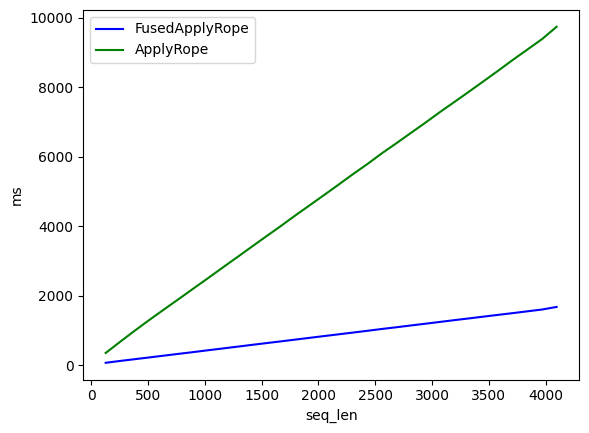

backward:
    seq_len  FusedApplyRope    ApplyRope
0     128.0       71.536772   354.313761
1     256.0      124.859698   678.329825
2     384.0      175.174996   996.210277
3     512.0      225.762412  1304.548860
4     640.0      276.758522  1603.955030
5     768.0      328.054488  1899.845481
6     896.0      378.031909  2199.207067
7    1024.0      430.370331  2496.592283
8    1152.0      481.057167  2798.862934
9    1280.0      532.589614  3097.526312
10   1408.0      584.110260  3399.021387
11   1536.0      635.149598  3698.171139
12   1664.0      685.451746  3994.641066
13   1792.0      736.880779  4300.382137
14   1920.0      788.349807  4596.955299
15   2048.0      839.526474  4894.154072
16   2176.0      890.197992  5194.549561
17   2304.0      940.973938  5499.653339
18   2432.0      992.371023  5793.086052
19   2560.0     1045.391440  6103.139877
20   2688.0     1094.375730  6393.602848
21   2816.0     1146.269441  6690.552711
22   2944.0     1196.803331  6987.261295
23   3

In [80]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 32+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['FusedApplyRope', 'ApplyRope'],  # possible values for `line_arg``
        line_names=[
            "FusedApplyRope",
            "ApplyRope",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'qh':32, 'kh':32, 'head_dim': 128, 'bs': 8}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, head_dim,qh, kh, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    q = torch.randn(bs, seq_len, qh, head_dim, device=device, dtype=dtype).transpose(1,2)
    k = torch.randn(bs, seq_len, kh, head_dim, device=device, dtype=dtype).transpose(1,2)
    q.requires_grad_(True)
    k.requires_grad_(True)
    cos = torch.randn(bs, seq_len, head_dim, device=device, dtype=dtype)
    sin = torch.randn_like(cos)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'FusedApplyRope':
        a,b = fused_apply_rope(q, k, cos, sin)
        loss = (a * repeat_kv(b, qh//kh)).sum()
        ms = triton.testing.do_bench(lambda: loss.backward(retain_graph=True), grad_to_none=[q,k])
    if provider == 'ApplyRope':
        a,b = apply_rotary_pos_emb(q, k, cos, sin)
        loss = (a * repeat_kv(b, qh//kh)).sum()
        ms = triton.testing.do_bench(lambda: loss.backward(retain_graph=True), grad_to_none=[q,k])

    return ms * 1e3
# print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


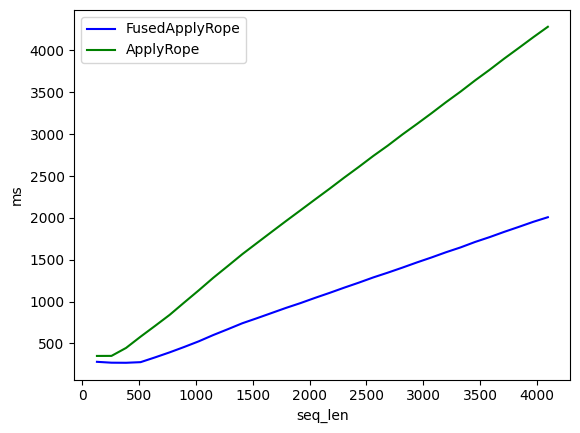

backward:
    seq_len  FusedApplyRope    ApplyRope
0     128.0      281.193316   351.407826
1     256.0      270.735890   351.938546
2     384.0      269.675225   446.875662
3     512.0      277.122408   581.544459
4     640.0      334.372938   710.655987
5     768.0      394.270897   842.100501
6     896.0      458.595008   989.461362
7    1024.0      525.929153  1134.757876
8    1152.0      601.164639  1284.880877
9    1280.0      670.698345  1425.306797
10   1408.0      742.008269  1567.636132
11   1536.0      801.861703  1699.652195
12   1664.0      863.411129  1831.454039
13   1792.0      925.185144  1962.548256
14   1920.0      982.792199  2091.168165
15   2048.0     1045.111775  2220.726490
16   2176.0     1104.614854  2348.866701
17   2304.0     1166.715145  2480.809689
18   2432.0     1226.299882  2608.220339
19   2560.0     1289.021134  2739.694357
20   2688.0     1346.067309  2863.408089
21   2816.0     1405.915260  2995.761395
22   2944.0     1468.086600  3121.158838
23   3

In [ ]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 32+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['FusedApplyRope', 'ApplyRope'],  # possible values for `line_arg``
        line_names=[
            "FusedApplyRope",
            "ApplyRope",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'qh':16, 'kh':8, 'head_dim': 128, 'bs': 8}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, head_dim,qh, kh, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    q = torch.randn(bs, seq_len, qh, head_dim, device=device, dtype=dtype).transpose(1,2)
    k = torch.randn(bs, seq_len, kh, head_dim, device=device, dtype=dtype).transpose(1,2)
    q.requires_grad_(True)
    k.requires_grad_(True)
    cos = torch.randn(bs, seq_len, head_dim, device=device, dtype=dtype)
    sin = torch.randn_like(cos)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'FusedApplyRope':
        a,b = fused_apply_rope(q, k, cos, sin)
        loss = (a.contiguous() * repeat_kv(b, qh//kh).contiguous()).sum()
        ms = triton.testing.do_bench(lambda: loss.backward(retain_graph=True), grad_to_none=[q,k])
    if provider == 'ApplyRope':
        a,b = apply_rotary_pos_emb(q, k, cos, sin)
        loss = (a.contiguous() * repeat_kv(b, qh//kh).contiguous()).sum()
        ms = triton.testing.do_bench(lambda: loss.backward(retain_graph=True), grad_to_none=[q,k])

    return ms * 1e3
# print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


# forward + backward

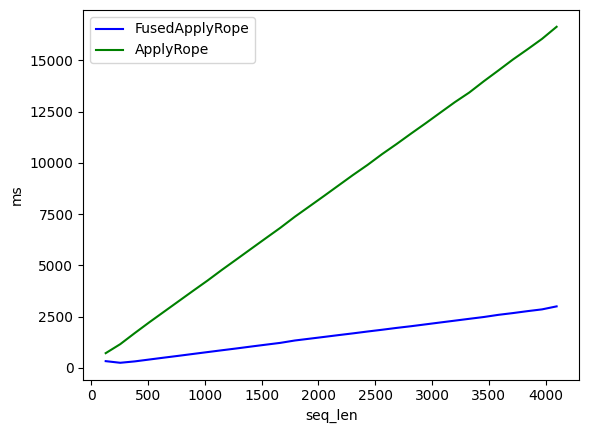

forward + backward:
    seq_len  FusedApplyRope     ApplyRope
0     128.0      331.267864    720.717549
1     256.0      251.625836   1159.904003
2     384.0      319.613069   1700.867534
3     512.0      410.856277   2227.354765
4     640.0      501.963377   2737.264156
5     768.0      590.719163   3247.121811
6     896.0      682.296693   3757.365704
7    1024.0      772.882819   4260.835171
8    1152.0      862.961590   4788.694382
9    1280.0      951.535940   5298.236847
10   1408.0     1043.775797   5811.450005
11   1536.0     1133.754969   6322.833061
12   1664.0     1222.221494   6830.530643
13   1792.0     1338.012457   7372.162819
14   1920.0     1424.792886   7876.528263
15   2048.0     1511.939526   8382.307053
16   2176.0     1600.391865   8896.050453
17   2304.0     1686.105847   9408.796310
18   2432.0     1776.590347   9900.398254
19   2560.0     1862.151980  10427.466393
20   2688.0     1952.623963  10920.503616
21   2816.0     2035.525322  11432.864189
22   2944.0   

In [4]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 32+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['FusedApplyRope', 'ApplyRope'],  # possible values for `line_arg``
        line_names=[
            "FusedApplyRope",
            "ApplyRope",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward + backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'qh':32, 'kh':32, 'head_dim': 128, 'bs': 8}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, head_dim,qh, kh, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    q = torch.randn(bs, seq_len, qh, head_dim, device=device, dtype=dtype).transpose(1,2)
    k = torch.randn(bs, seq_len, kh, head_dim, device=device, dtype=dtype).transpose(1,2)
    q.requires_grad_(True)
    k.requires_grad_(True)
    cos = torch.randn(bs, seq_len, head_dim, device=device, dtype=dtype)
    sin = torch.randn_like(cos)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    def fwd_bwd(func, *args):
        a,b = func(*args)
        loss = (a * repeat_kv(b, qh//kh)).sum()
        loss.backward(retain_graph=True)

    if provider == 'FusedApplyRope':
        ms = triton.testing.do_bench(lambda: fwd_bwd(fused_apply_rope, q, k, cos, sin), grad_to_none=[q,k])
    if provider == 'ApplyRope':
        ms = triton.testing.do_bench(lambda: fwd_bwd(apply_rotary_pos_emb, q, k, cos, sin), grad_to_none=[q,k])

    return ms * 1e3
# print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)
